# Calculating Similarity between Eastenders Characters by performing NLP tasks

An Eastenders script data document (ie the file training.csv) is going to be used to create a vector representation of the lines said by each character, and then we'll work to improve that representation so each character document is clearly distinguishable from the rest of them. An evaluation of this difference is based on the ability of a basic information retrieval classification algorithm to correctly classify documents from validation and test data (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).


In [1]:
pip install vaderSentiment

In [2]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
from sklearn.feature_extraction import DictVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
%matplotlib inline
pd.options.display.max_colwidth=500

In [4]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path, skip_blank_lines = True, header=None, names=['Line','Character','Gender'])
test_path ='test.csv'
test_data = pd.read_csv(test_path, skip_blank_lines = True, header=None, names=['Line','Character','Gender'])
# Inspecting training data
all_train_data

,Line,Character,Gender
0,Someone had fun.,SEAN,male
1,"It's no problem, honestly. Go on, go and open the launderette. Leave it with me.",SHIRLEY,female
2,Last night was better than ever. What's all this? Anything interesting?,MAX,male
3,Have you checked the answerphone? Any calls?,IAN,male
4,Oscar's asleep.,MAX,male
...,...,...,...
10108,"What's going on Gal? What's going on? I don't understand mate. You said you were gonna go and get her, you promised...",MINTY,male
10109,Am I mad? Have I completely lost it?,TANYA,female
10110,You're late.,JACK,male
10111,Ask your psycho Ex.,ROXY,female


In [5]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
print('Raw Data: ',np.shape(all_train_data))
idx = int(0.9 * np.shape(all_train_data)[0])
train_data = all_train_data[:idx]
val_data = all_train_data[idx:]
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (10113, 3)
Train set:  (9101, 3)
Validation set:  (1012, 3)


In [6]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """An end of line (_EOL_) marker is placed between each line of the character's text, which is returned as a single string."""
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [7]:
# In the training set, print out the total number of words for each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SEAN': 360, 'SHIRLEY': 360, 'MAX': 360, 'IAN': 360, 'MINTY': 360, 'RONNIE': 360, 'STACEY': 360, 'JANE': 360, 'PHIL': 360, 'CLARE': 359, 'TANYA': 360, 'HEATHER': 360, 'GARRY': 308, 'BRADLEY': 292, 'CHRISTIAN': 357, 'STEVEN': 268, 'ROXY': 360, 'JACK': 360}
Num. Characters:  18 

SEAN Number of Words:  3629
SHIRLEY Number of Words:  4023
MAX Number of Words:  4627
IAN Number of Words:  4165
MINTY Number of Words:  3914
RONNIE Number of Words:  3528
STACEY Number of Words:  3979
JANE Number of Words:  3818
PHIL Number of Words:  3950
CLARE Number of Words:  4311
TANYA Number of Words:  4092
HEATHER Number of Words:  4040
GARRY Number of Words:  3599
BRADLEY Number of Words:  2865
CHRISTIAN Number of Words:  3979
STEVEN Number of Words:  2485
ROXY Number of Words:  3824
JACK Number of Words:  4110
total words 68938


In [8]:
def pre_process(character_text):
    """Tokenization, spelling normalisation, and other techniques are used to pre-process the concatenated lines of a character.
    """
    tokenizer = RegexpTokenizer(r'\w+')
    sentence_list = character_text.split('_EOL_') ## Splitting a long string into individual lines is done with the letter _EOL_.
    score_list = [] ## list where the sentiment analysisi scores will be stored
    ner_list = [] # list where the trees provided by NER will be stored
    pos_tag_list = []
    for sent in sentence_list: ## Iterating over the lines one by one
        score = analyser.polarity_scores(sent) ## on-line sentiment analysis is carried out
        score_list.append((score['neg'],score['pos'], score['neu'], score['compound'])) ## the sentiment analysis findings are added to the list
        tokens2 = tokenizer.tokenize(sent)## Tokenize the line and delete the punctuation in this step.
        tokens_tagged = pos_tag(tokens2) ## Get the tokens' POS tags.
        pos_tag_list.append([tup[1] for tup in tokens_tagged]) ## Obtains the pos tags for each and every line.
        ner_list.append(nltk.ne_chunk(tokens_tagged,binary=False)) ## save the trees in the list by performing NER
    tokens = tokenizer.tokenize(character_text) ## Tokenize character text and remove punctuation in the following line of code.
    tokens = [word.lower() for word in tokens] ## all tokens should be converted to lowercase
    stop = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop] ## Take out all stop words from the tokens
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(word) for word in tokens] ## On the tokens, perform lemmatisation
    return tokens ##, score_list, ner_list, pos_tag_list --> These would be the extra things to add in the return if we were to use them as features

In [9]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [10]:
def to_feature_vector_dictionary(character_doc): ##, sentiment_scores, ner_list, pos_tag_list): --> These would be the extra things to add in the return if we were to use them as features
    """Token-based conversion to a Dictionary from a list of pre-processed tokens and additional features."""
    ## Note: only the code that corresponds to the best attemopt is displayed in this function, for the other attemps I provide a snippet of code that was added here during the attempt
    feature_dict = {}
    tags = pos_tag(character_doc)
    pos_tag_list = [tup[1] for tup in tags] ## get all the pos tags into a list
    for val in character_doc: ## for every token in the character_doc we count how many times it appeared
        try:
            feature_dict['count_'+str(val)]+=1
        except:
            feature_dict['count_'+str(val)]=1
    i=0
    for value in pos_tag_list: ## we add all the pos tag values as features 
        try:
            feature_dict['pos_tag_'+str(i)]=value
        except:
            feature_dict['pos_tag_'+str(i)]=value
        i+=1 
    j=0
    return feature_dict

In [11]:
corpusVectorizer = DictVectorizer()   # CorpusVectorizor, which will only generate sparse vectors from feature dictionaries
def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers on data and returns a matrix."""
    
    # makes use of the corpus Vectorizer's global variable to enhance outcomes
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [12]:
# only 40 lines are used for each character in the validation data
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)
# create a list of all the possible pairs (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'IAN': 40, 'STACEY': 40, 'JANE': 40, 'SEAN': 40, 'CLARE': 40, 'MAX': 40, 'TANYA': 40, 'JACK': 40, 'SHIRLEY': 40, 'RONNIE': 40, 'MINTY': 39, 'GARRY': 32, 'STEVEN': 30, 'BRADLEY': 40, 'ROXY': 40, 'CHRISTIAN': 40, 'HEATHER': 40, 'PHIL': 40}
Num. Characters:  18 

IAN Num of Words:  611
STACEY Num of Words:  409
JANE Num of Words:  503
SEAN Num of Words:  414
CLARE Num of Words:  512
MAX Num of Words:  411
TANYA Num of Words:  399
JACK Num of Words:  434
SHIRLEY Num of Words:  419
RONNIE Num of Words:  362
MINTY Num of Words:  555
GARRY Num of Words:  387
STEVEN Num of Words:  312
BRADLEY Num of Words:  509
ROXY Num of Words:  376
CHRISTIAN Num of Words:  517
HEATHER Num of Words:  543
PHIL Num of Words:  411
total words 8084


In [13]:
# don't fit the val feature matrix, just transform it
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [14]:
def compute_cosine_similarity(v1, v2):
    """It accepts two vectors v1 and v2 as input (1-d arrays e.g. [0, 0.5, 0.5]) results in a comparison of the cosine similarity of the vectors."""
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    return manual_cosine_similarity

In [15]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """Returns a 4-tuple after computing a data retrieval based on the feature matrix of training and test data."""
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    # compare training and test documents by their similarity scores using the dafaframe.
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],'similarity': pairwise_cosine_similarity})
    # displays characters that are most and least similar to each other
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [16]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, round(cm[i][j],3),ha="center", va="center", color="w")
    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    plt.show()

mean rank 1.2222222222222223
mean cosine similarity 0.898209808687026
15 correct out of 18 / accuracy: 0.8333333333333334


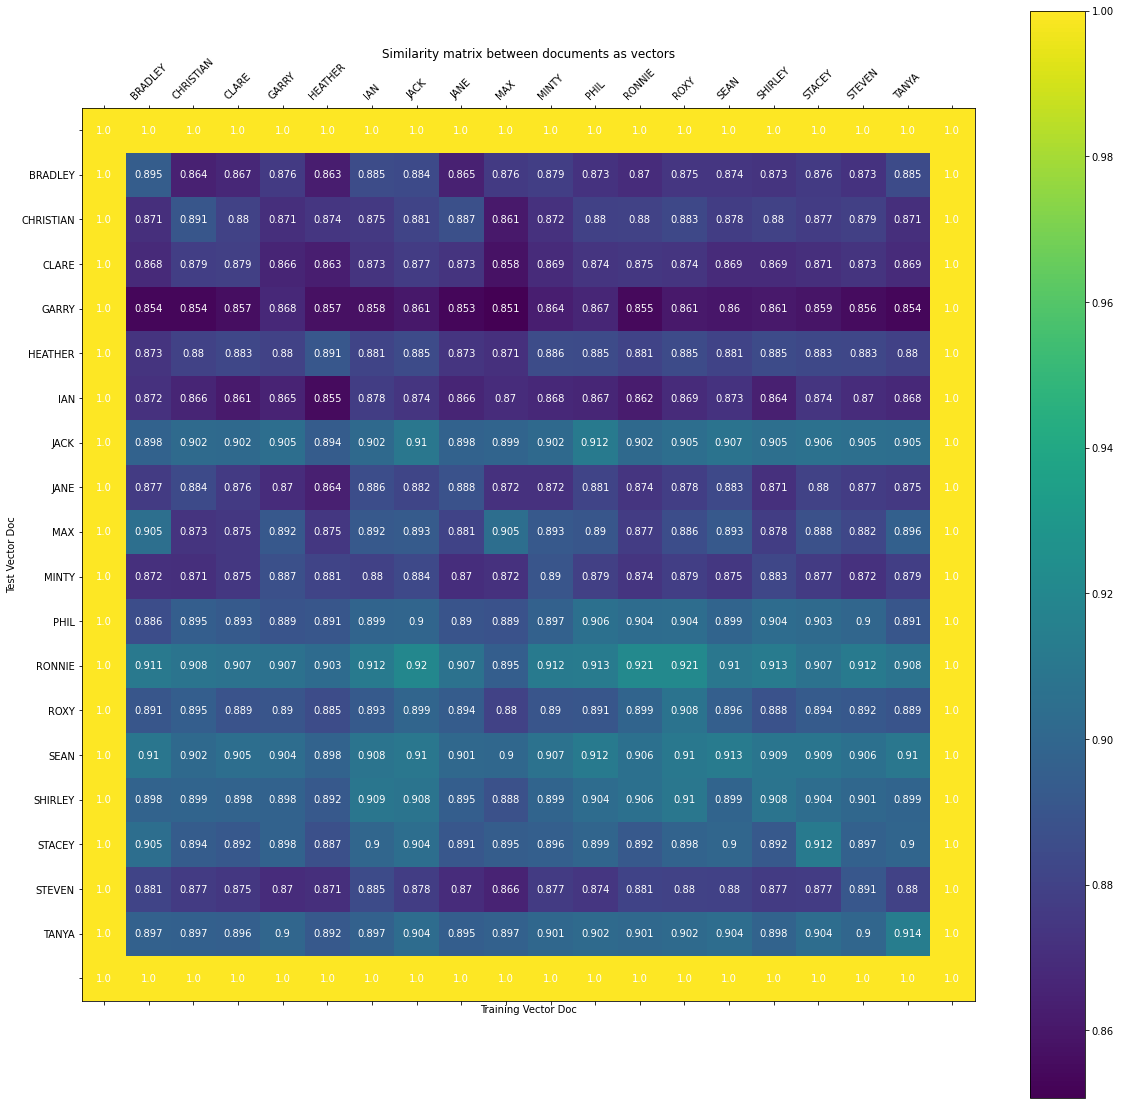

In [17]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
plot_heat_map_similarity(df)

Token counts are added to the values of the pos tags, not the counts. We achieve a higher accuracy and a lower mean rank value than various other attempts with different combinations of features.
The Code:

<code>
    tags = pos_tag(character_doc)
    pos_tag_list = [tup[1] for tup in tags]
    for val in character_doc:
        try:
            feature_dict['count_'+str(val)]+=1
        except:
            feature_dict['count_'+str(val)]=1
    i=0
    for value in pos_tag_list:
        try:
            feature_dict['pos_tag_'+str(i)]=value
        except:
            feature_dict['pos_tag_'+str(i)]=value
        i+=1 
</code>


### Results:

mean rank 1.2222222222222223


mean cosine similarity 0.898209808687026


15 correct out of 18 / accuracy: 0.8333333333333334


